In [1]:
import numpy as np
import scipy.interpolate
import matplotlib.pyplot as plt
import matplotlib.colorbar as cb
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1 import ImageGrid

import sys

In [21]:
#    RIXS=np.loadtxt(pathDataRe,dtype=complex)
#    RIXS.imag=np.loadtxt(pathDataIm)
def get_Rixs(path):
    RIXS=np.loadtxt(path,skiprows=5)
    RIXS = RIXS.T[1:]
    #RIXS_Real=[]
    RIXS_Img=[]
    for i in range(0,int(len(RIXS)/2)):
        #RIXS_Real.append(RIXS[2*i])
        RIXS_Img.append(RIXS[2*i+1])
    return -np.flip(np.array(RIXS_Img).T,axis=0)

def shift_y_to_zero(RIXS):
    i_white = int(np.mean(np.argmax(RIXS,axis=1)))
    j_white = np.argmax(RIXS.T[i_white])
    j_min = j_white-10000
    if j_min<0: j_min=0
    j_max = j_white+10000
    if j_max>len(RIXS)-1: j_max=len(RIXS)-1
    RIXS_shifted=np.zeros([20001,61])
    RIXS_shifted[10000-(j_white-j_min):10000+(j_max-j_white)]=RIXS[j_min:j_max]
    return RIXS_shifted

def get_RIXS_list(name,type,edge):
    RIXS_z_z       = get_Rixs(name + "/data/RIXS/"+type+"/"+edge+"/RIXS_z_z.dat")
    RIXS_z_x       = get_Rixs(name + "/data/RIXS/"+type+"/"+edge+"/RIXS_z_x.dat")
    RIXS_zpx_zpx   = get_Rixs(name + "/data/RIXS/"+type+"/"+edge+"/RIXS_zpx_zpx.dat")
    RIXS_zpix_zpix = get_Rixs(name + "/data/RIXS/"+type+"/"+edge+"/RIXS_zpix_zpix.dat")
    return [RIXS_z_z,RIXS_z_x,RIXS_zpx_zpx,RIXS_zpix_zpix]

def project_tensor(RIXS_tensor,coefficients):
    #"xx|xx,xy|xy,xy|yx,xx|yy"
    RIXS=0
    for i in range(4):
        RIXS=RIXS+coefficients[i]*RIXS_tensor[i]
    return RIXS
    
def calculate_Oh_powder_INE_90Pi(RIXS_tensor,CrystalNumber="3"):
    if CrystalNumber=="3":
        coefficients=[7.23302,8.76698,-7.23302,-7.23302]
    
    elif CrystalNumber=="2":
        coefficients=[7.19198,8.80802,-7.07679,-7.07679]
    
    elif CrystalNumber=="1":
        coefficients=[7.07348,8.92652,-6.625,-6.62557]
    else:
        print("Crystal Number not recognized")
    return project_tensor(RIXS_tensor,coefficients)

def get_RIXS_tensor(RIXS_z_z,RIXS_z_x,RIXS_zx_zx,RIXS_zix_zix):
    RIXS_list = [RIXS_z_z,RIXS_z_x,RIXS_zx_zx,RIXS_zix_zix]
    Sum_T = [[1,0,0,0],[0,1,0,0],[-1,-1,1,1],[0,0,1,-1]] 
    Tensor= []
    for i in range(4): 
        RIXS=0
        for j in range(4):
            RIXS=RIXS+Sum_T[i][j]*RIXS_list[j]
        Tensor.append(RIXS)
    return Tensor


def get_axis(RIXS,E_exc_limits,E_em_limits):
    E_exc = np.linspace(*E_exc_limits, len(RIXS[0]))
    E_em  = np.linspace(*E_em_limits,  len(RIXS))
    return E_exc, E_em
    
def transform_RIXS(E_exc,E_em,RIXS,N_x,N_y):
    #mesh = np.meshgrid(E_exc, E_em, indexing='ij', sparse=True)
    #RIXS_int=scipy.interpolate.RegularGridInterpolator((E_exc,E_em),RIXS.T,fill_value=0,bounds_error=False)#
    RIXS_int=scipy.interpolate.RectBivariateSpline(E_exc,E_em,RIXS.T)#
    RIXS_trans=np.zeros([N_x,N_y])
    x=np.linspace(min(E_exc),max(E_exc),N_x)
    y=np.linspace(min(E_em),max(E_em),N_y)
    for i in range(len(x)):
        for j in range(len(y)):
                RIXS_trans[i,j]=RIXS_int(x[i],-x[i]+y[j]) 
    return np.flip(RIXS_trans.T,axis=0)
    
def get_powder_RIXS(name,type,edge):
    RIXS_list   = get_RIXS_list(name,type,edge)
    RIXS_tensor = get_RIXS_tensor(*RIXS_list)
    return calculate_Oh_powder_INE_90Pi(RIXS_tensor)
    
def get_experiment_RIXS_from_powder(RIXS_powder,E_exc_limits,E_em_limits,N_x,N_y):
    E_exc,E_em  = get_axis(RIXS_powder,E_exc_limits,E_em_limits)
    return transform_RIXS(E_exc,E_em,RIXS_powder,N_x,N_y)

def plot_RIXS_row(RIXS, label, xrange, yrange, xlims=False, ylims=False,aspect=1):
    if not xlims:
        xlims= xrange
    if not ylims:
        ylims= yrange 
    fig = plt.figure(figsize=(int(4*len(RIXS)), 4))
    grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                     nrows_ncols=(1,int(len(RIXS))),
                     axes_pad=0.15,
                     share_all=True,
                     cbar_location="right",
                     cbar_mode="single",
                     cbar_size="7%",
                     cbar_pad=0.15,
                     )
    
    grid[0].set_ylabel("relative E$_{em} [eV]$")
    
    for i,ax in enumerate(grid):
        ax.set_xlabel("relative E$_{exc}$ [eV]")
        ax.set_title(label[i])
        ax.set_xlim(*xlims)
        ax.set_ylim(*ylims)
        im = ax.imshow(RIXS[i]/RIXS[i].max(),extent=[*xrange,*yrange],aspect=aspect)
        if i != 0:
            ax.axes.get_yaxis().set_visible(False)
    # Colorbar
    ax.cax.cla() 
    cb.Colorbar(ax.cax,im)
    fig.subplots_adjust(right=.65,left=0)

def get_XANES(RIXS):
    return np.linspace(-8,12,len(RIXS[0])),RIXS[int(len(RIXS)/2)]

def plot_XANES(RIXS_No_M4,RIXS_6d_M4,RIXS_No_M5,RIXS_6d_M5,xlim,ylim):
    M4_small = get_XANES(RIXS_No_M4)
    M4_large = get_XANES(RIXS_6d_M4)
    
    M5_small = get_XANES(RIXS_No_M5)
    M5_large = get_XANES(RIXS_6d_M5)
    
    fig =plt.figure(figsize=(10,4))
    ax1 = plt.subplot(121)
    ax1.plot(*M4_small,label="without 6d")
    ax1.plot(*M4_large,label="with 6d")
    ax1.set_xlim(*xlim)
    ax1.set_ylim(*ylim)  
    ax1.set_title("M4")
    ax1.legend()
    
    ax2 = plt.subplot(122)
    ax2.plot(*M5_small,label="without 6d")
    ax2.plot(*M5_large,label="with 6d")
    ax2.set_title("M5")
    ax2.set_xlim(*xlim)
    ax2.set_ylim(*ylim)   
    ax2.legend()

# Sr3UO6

In [6]:
Sr3UO6_No_M4_powder = shift_y_to_zero(get_powder_RIXS("Sr3UO6","No","M4"))
Sr3UO6_6d_M4_powder = shift_y_to_zero(get_powder_RIXS("Sr3UO6","6d","M4"))
Sr3UO6_No_M4 = get_experiment_RIXS_from_powder(Sr3UO6_No_M4_powder,[-8,12],[-20,20],1000,1000)
Sr3UO6_6d_M4 = get_experiment_RIXS_from_powder(Sr3UO6_6d_M4_powder,[-8,12],[-20,20],1000,1000)
Sr3UO6_No_M5_powder = shift_y_to_zero(get_powder_RIXS("Sr3UO6","No","M5"))
Sr3UO6_6d_M5_powder = shift_y_to_zero(get_powder_RIXS("Sr3UO6","6d","M5"))
Sr3UO6_No_M5 = get_experiment_RIXS_from_powder(Sr3UO6_No_M5_powder,[-8,12],[-20,20],1000,1000)
Sr3UO6_6d_M5 = get_experiment_RIXS_from_powder(Sr3UO6_6d_M5_powder,[-8,12],[-20,20],1000,1000)
labels = ["without 6d","with 6d"]

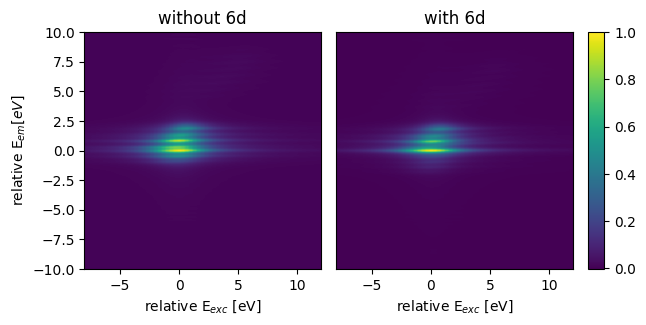

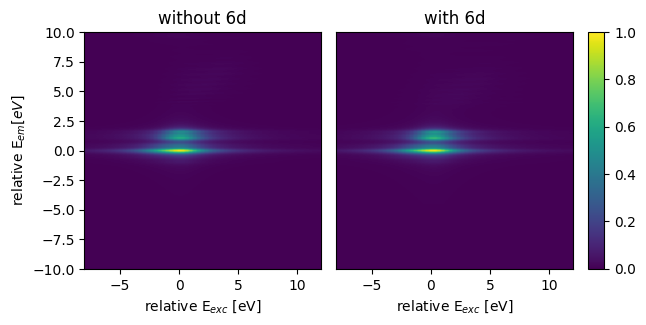

In [7]:
plot_RIXS_row([Sr3UO6_No_M4_powder, Sr3UO6_6d_M4_powder], labels, [-8,12], [-20,20], [-8,12], [-10,10])
plot_RIXS_row([Sr3UO6_No_M5_powder, Sr3UO6_6d_M5_powder], labels, [-8,12], [-20,20], [-8,12], [-10,10])

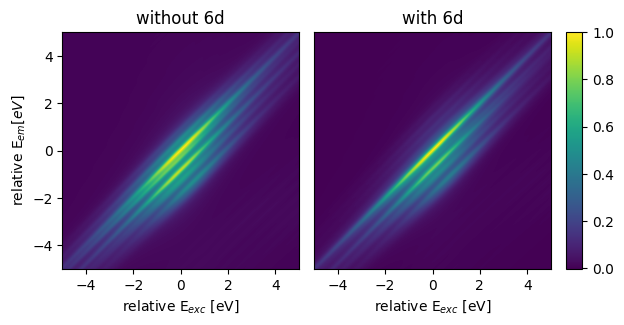

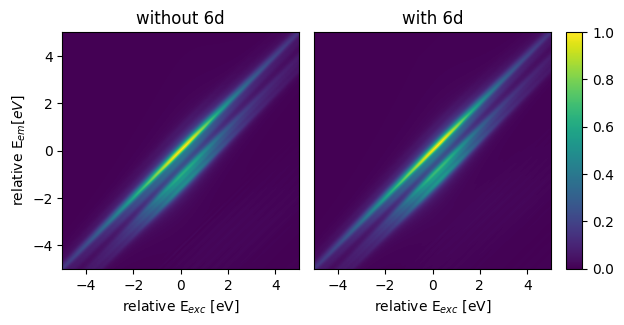

In [8]:
plot_RIXS_row([Sr3UO6_No_M4, Sr3UO6_6d_M4], labels, [-8,12], [-20,20], [-5,5], [-5,5])
plot_RIXS_row([Sr3UO6_No_M5, Sr3UO6_6d_M5], labels, [-8,12], [-20,20], [-5,5], [-5,5])

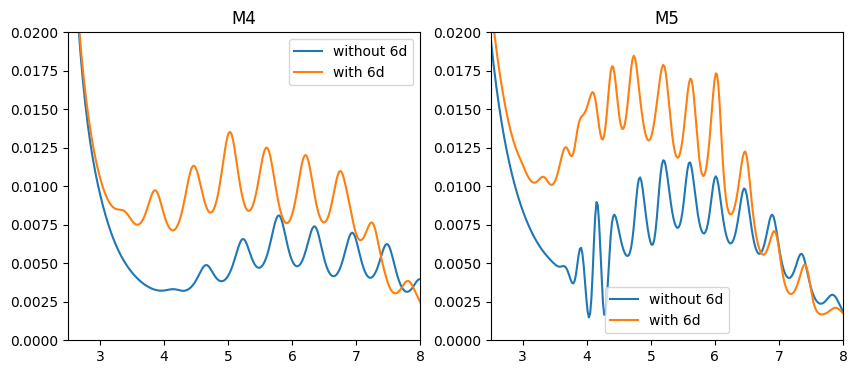

In [25]:
plot_XANES(Sr3UO6_No_M4, Sr3UO6_6d_M4, Sr3UO6_No_M5, Sr3UO6_6d_M5,xlim=[2.5,8],ylim=[0,0.02])

# Ba3UO6

In [10]:
Ba3UO6_No_M4_powder = shift_y_to_zero(get_powder_RIXS("Ba3UO6","No","M4"))
Ba3UO6_No_M4 = get_experiment_RIXS_from_powder(Ba3UO6_No_M4_powder,[-8,12],[-20,20],1000,1000)

Ba3UO6_6d_M4_powder = shift_y_to_zero(get_powder_RIXS("Ba3UO6","6d","M4"))
Ba3UO6_6d_M4 = get_experiment_RIXS_from_powder(Ba3UO6_6d_M4_powder,[-8,12],[-20,20],1000,1000)

Ba3UO6_No_M5_powder = shift_y_to_zero(get_powder_RIXS("Ba3UO6","No","M5"))
Ba3UO6_No_M5 = get_experiment_RIXS_from_powder(Ba3UO6_No_M5_powder,[-8,12],[-20,20],1000,1000)

Ba3UO6_6d_M5_powder = shift_y_to_zero(get_powder_RIXS("Ba3UO6","6d","M5"))
Ba3UO6_6d_M5 = get_experiment_RIXS_from_powder(Ba3UO6_6d_M5_powder,[-8,12],[-20,20],1000,1000)
labels = ["without 6d","with 6d"]

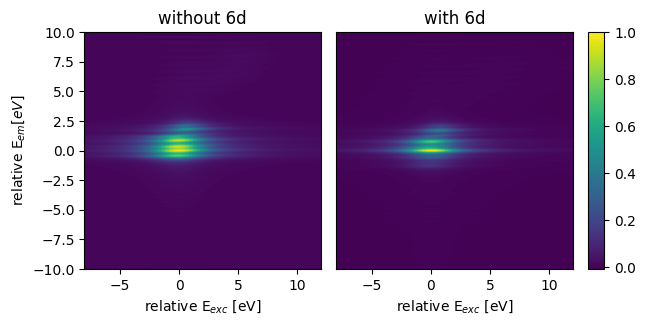

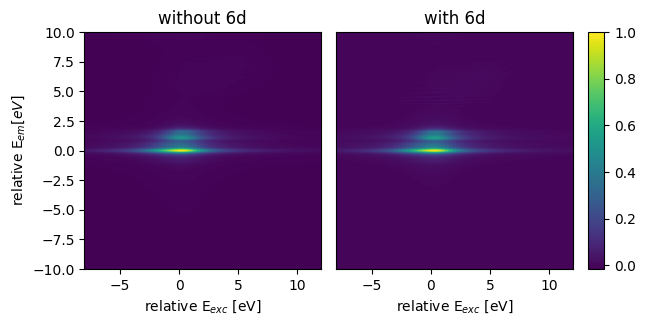

In [11]:
plot_RIXS_row([Ba3UO6_No_M4_powder, Ba3UO6_6d_M4_powder], labels, [-8,12], [-20,20], [-8,12], [-10,10])
plot_RIXS_row([Ba3UO6_No_M5_powder, Ba3UO6_6d_M5_powder], labels, [-8,12], [-20,20], [-8,12], [-10,10])

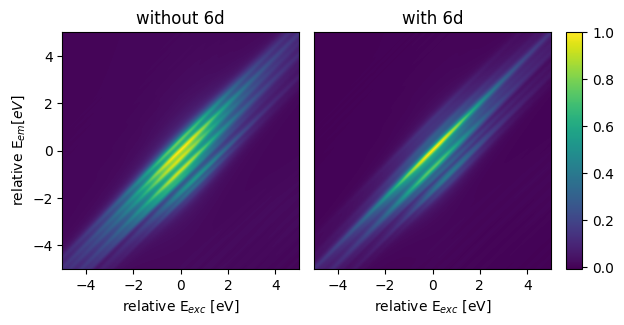

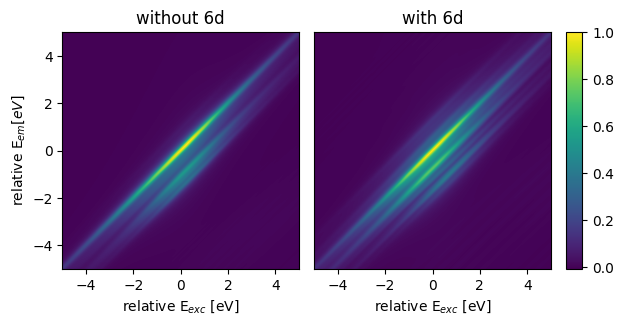

In [12]:
plot_RIXS_row([Ba3UO6_No_M4, Ba3UO6_6d_M4], labels, [-8,12], [-20,20], [-5,5], [-5,5])
plot_RIXS_row([Ba3UO6_No_M5, Ba3UO6_6d_M4], labels, [-8,12], [-20,20], [-5,5], [-5,5])

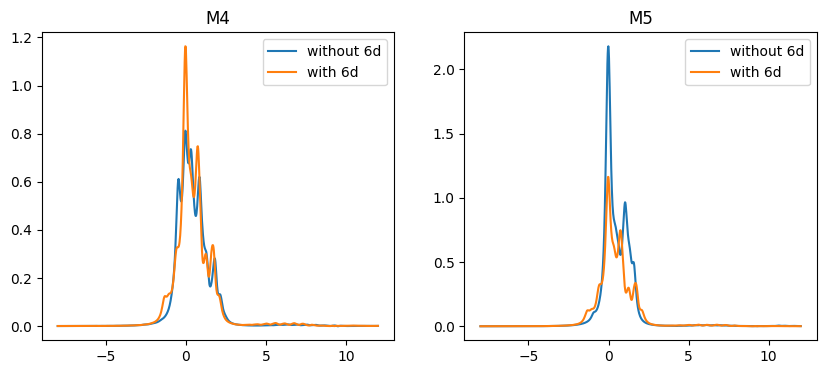

In [16]:
plot_XANES(Ba3UO6_No_M4, Ba3UO6_6d_M4, Ba3UO6_No_M5, Ba3UO6_6d_M4)